In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats.distributions as dist
import nltk
from collections import defaultdict
from nltk.util import trigrams
import seaborn as sns
import pandas as pd 

In [ ]:
#Read in data

ai_file = open('/content/drive/MyDrive/CompLingFinalProject/complete_eli5_chatgpt_responses_cleaned.txt')
ai_data = ai_file.readlines()
ai_file.close()

human_file = open('/content/drive/MyDrive/CompLingFinalProject/complete_true_eli5_chatgpt_responses.txt')
human_data = human_file.readlines()
human_file.close  

ai_data = [l.strip() for l in ai_data] #load data and remove start and end lines
human_data = [l.strip() for l in human_data]

In [ ]:
print(len(ai_data))
print(len(human_data))

16532
16669


In [ ]:
def flatten(lst):
  return [elt for sl in lst for elt in sl]

In [ ]:
from nltk.lm import MLE
import math


#generate 3, 2, 1grams for all data with padding
train_ai, vocab_ai = nltk.lm.preprocessing.padded_everygram_pipeline(3, ai_data[:math.ceil(0.8 * len(ai_data))])
train_human, vocab_human = nltk.lm.preprocessing.padded_everygram_pipeline(3, human_data[:math.ceil(0.8 * len(human_data))])

#Create MLE models
lm_ai = MLE(3)
lm_ai.fit(train_ai, vocab_ai)

lm_human = MLE(3)
lm_human.fit(train_human, vocab_human)

In [ ]:
from nltk.lm.preprocessing import pad_both_ends

#Test the models on teh rest of the data set, assigning to whichever class has lower cost
#also record perplexity

def score(sent, model):
  score = 0
  for i in range(2, len(sent)):
    score += (-model.logscore(sent[i], sent[i-2:i]))
  return score

TP, FP, TN, FN = 0,0,0,0

#AI - Human
diff = []
#AI = 1, Human = 0
typ = [] 
#if it was classified correctly
right = []

#Store perplexities of AI model
AI_got_perp = []
AI_fail_perp = []
Human_got_perp = []
Human_fail_perp = []


#we define positive as AI for the sake of the confusion matrix

for s in ai_data[math.ceil(0.8 * len(ai_data)):]:
  s = list(pad_both_ends(s, n=3))
  AIscore = score(s, lm_ai)
  Hscore = score(s, lm_human)
  try:
    diff.append(abs((AIscore - Hscore)/(AIscore + Hscore)))
    typ.append(1)
    if AIscore < Hscore:
      TP += 1
      right.append(1)
      AI_got_perp.append(lm_ai.perplexity(trigrams(s)))
    else:
      FN += 1
      right.append(0)
      AI_fail_perp.append(lm_human.perplexity(trigrams(s)))
  except:
    pass
    # print(s, AIscore, Hscore)
  

for s in human_data[math.ceil(0.8 * len(human_data)):]:
  s = list(pad_both_ends(s, n=3))
  AIscore = score(s, lm_ai)
  Hscore = score(s, lm_human)
  try:
    diff.append(abs((AIscore - Hscore)/(AIscore+Hscore)))
    typ.append(0)
    if Hscore < AIscore:
      TN += 1
      right.append(1)
      Human_got_perp.append(lm_human.perplexity(trigrams(s)))
    else:
      FP += 1
      right.append(0)
      Human_fail_perp.append(lm_human.perplexity(trigrams(s)))
  except:
    pass
    # print(s, AIscore, Hscore)

sensitivity = TP/(TP + FN)
precision = TP/(TP+FP)
accuracy = (TP+TN)/(TP+FP+TN+FN)
print(TP, FP, TN, FN, sensitivity, precision, accuracy)

2412 1837 1496 894 0.7295825771324864 0.567662979524594 0.5886428679017924


This is very bad, but its a bigram, so its what we expect, perplexity is also not a good metric. So what would be more helpful is just general bag of words approach possibly, just see does its word pool lean more heavily towards AI words or not.

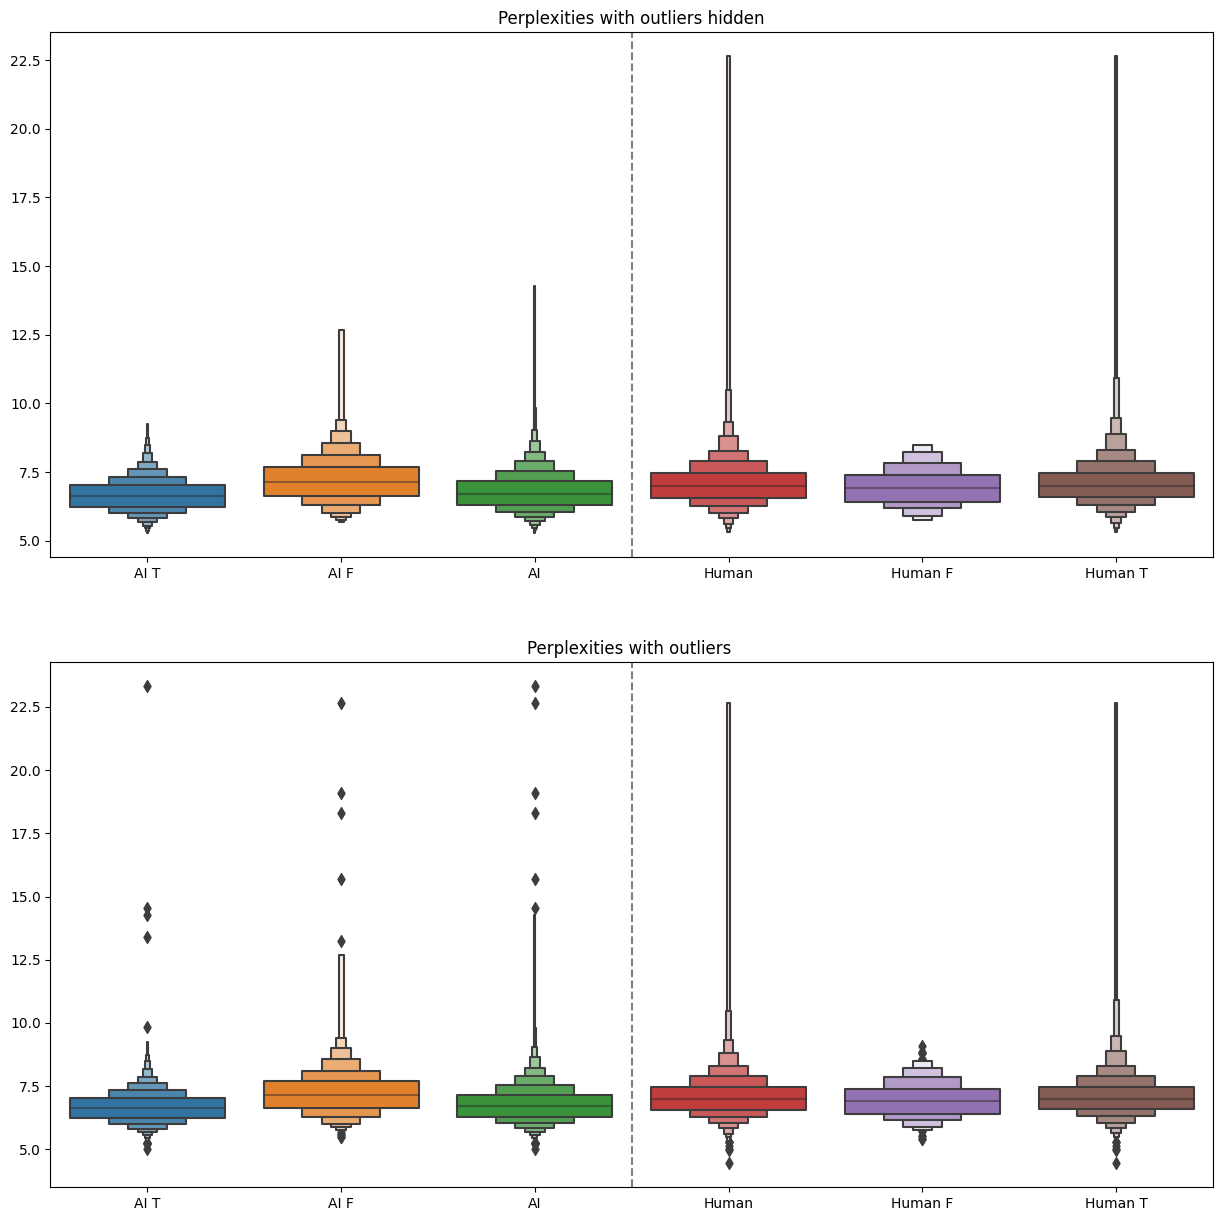

In [ ]:
#Plot perplexities

fig, ax = plt.subplots(2,1,figsize=(15,15))

AI_got_perp = [x for x in AI_got_perp if x != float("inf")]
AI_fail_perp = [x for x in AI_fail_perp if x != float("inf")]
Human_got_perp = [x for x in Human_got_perp if x != float("inf")]
Human_fail_perp = [x for x in Human_fail_perp if x != float("inf")]

bp1 = sns.boxenplot(ax = ax[0], data = [AI_got_perp, AI_fail_perp, AI_got_perp+AI_fail_perp, Human_got_perp + Human_fail_perp, Human_fail_perp, Human_got_perp], showfliers=False);
bp2 = sns.boxenplot(ax = ax[1], data = [AI_got_perp, AI_fail_perp, AI_got_perp+AI_fail_perp, Human_got_perp + Human_fail_perp, Human_fail_perp, Human_got_perp], showfliers=True);


labels = ["AI T", "AI F", "AI", "Human", "Human F", "Human T"]
ticks = list(range(0, len(labels)))

ax[0].axvline(x=2.5, linestyle='--', color='gray')
ax[1].axvline(x=2.5, linestyle='--', color='gray')

ax[0].set_title("Perplexities with outliers hidden")
ax[1].set_title("Perplexities with outliers ")

bp1.set_xticks(ticks, labels)
bp2.set_xticks(ticks, labels)

Looking at the perplexiites, they are all pretty similar, so trigrams alone do not do a good job predicting/modeling the data

We want to see if word frequencies can help with this. What we will do is find words that have large frequency differences between the two datasets. Using time since last occurance for words, we see if these distributions are substantially different

In [ ]:
from collections import defaultdict
from nltk.tokenize import word_tokenize
nltk.download('punkt')

#Funcitno to calculate distances bewteen word occurances

def calculate_last_pos(text, word_dist, last_pos, word_count):
  for i, w in enumerate(text):
    if w in ['.', ',', '(', ')', "'s", '*', "n't", "''", "``", '"', '`', "''", "'ve"]:
      continue
    word_count[w] += 1
    if last_pos[w] == None:
      last_pos[w] = i
    else:
      word_dist[w].append(i - last_pos[w])
      last_pos[w] = i

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
 
lemmatizer = WordNetLemmatizer()

#lower and lemmatize words -> lemmatizing decreases Zscores a bit, but not a lot
ai_text = flatten([word_tokenize(s) for s in ai_data])
ai_text = [lemmatizer.lemmatize(w.lower()) for w in ai_text]
human_text = flatten([word_tokenize(s) for s in human_data])
human_text = [lemmatizer.lemmatize(w.lower()) for w in human_text]

# ai_text = flatten([word_tokenize(s) for s in ai_data])
# ai_text = [w.lower() for w in ai_text]
# human_text = flatten([word_tokenize(s) for s in human_data])
# human_text = [w.lower() for w in human_text]

ai_word_dist = defaultdict(lambda : [])
human_word_dist = defaultdict(lambda : [])

ai_last_pos = defaultdict(lambda : None)
human_last_pos = defaultdict(lambda : None)

ai_word_counts = defaultdict(lambda:0)
human_word_counts = defaultdict(lambda :0)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
#Calculate the distributions

calculate_last_pos(ai_text, ai_word_dist, ai_last_pos, ai_word_counts)
calculate_last_pos(human_text, human_word_dist, human_last_pos, human_word_counts)

In [ ]:
#Sort distributions by greatest count

ai_most = sorted(ai_word_counts.items(), key=lambda x: x[1], reverse=True)
human_most = sorted(human_word_counts.items(), key=lambda x: x[1], reverse=True)

In [ ]:
from statistics import mean, stdev


#Z test to get difference between distribution
def ztest(word):
  try:
    meanai = mean(ai_word_dist[word])
    meanhuman = mean(human_word_dist[word])
    meandif = meanai - meanhuman
    denom = math.sqrt(pow(stdev(ai_word_dist[word]),2) + pow(stdev(human_word_dist[word]), 2))
    return meandif / denom
  except: 
    return 0 #fail say no difference
  
#perform z-test on all words that occur in each dataset at least 100 times
words = set([a for a,b in human_word_counts.items() if b >= 100]).intersection(set([a for a,b in ai_word_counts.items() if b >= 100]))
zstat = {word:ztest(word) for word in words}
#Take words with most differen Z-scores
zstat_most = sorted(zstat.items(), key= lambda x: abs(x[1]), reverse=True)

In [ ]:
print('info' in words)
print(zstat_most)
print(ai_word_dist['info'])
print(human_word_dist['info'])
print(ai_word_counts['info'])
print(human_word_counts['info'])

False
[('additionally', -0.897948802060756), ('including', -0.808698562378176), ('ensure', -0.769981738714222), ('potentially', -0.7519852219776704), ('now', 0.7448849969692628), ('since', 0.7433047571719322), ('variety', -0.7277324998540078), ('unique', -0.7201396486780609), ('create', -0.7198270943037701), ('scientist', -0.7149524738469747), ('i', 0.7030752178979802), ('help', -0.6860335232791427), ('cultural', -0.676903628511981), ('maintain', -0.6697422286896831), ('protect', -0.6637110864380642), ('communicate', -0.6557213920989327), ('difficult', -0.6499182229842615), ('leading', -0.6469253874848998), ('creates', -0.6400997798045552), ('creating', -0.6374483792180173), ('behavior', -0.6366132232119123), ('factor', -0.6280770286504411), ('affect', -0.6278729480094536), ('let', 0.6252519277723079), ('vary', -0.6119262803330647), ('may', -0.6110858068466346), ('properly', -0.6056020800504452), ('dangerous', -0.5976612145821686), ('designed', -0.5953727320366798), ('most', 0.59244796

In [ ]:
#Prepare dataframes for plotting

ai_most_diff = {a:ai_word_dist[a] for (a,b) in zstat_most[:12]}
human_most_diff = {a:human_word_dist[a] for (a,b) in zstat_most[:12]}

df_ai = pd.DataFrame.from_dict(ai_most_diff, orient='index').transpose()
df_ai_melted = df_ai.melt(var_name='word', value_name='count')
df_ai_melted['class'] = 'AI'

df_human = pd.DataFrame.from_dict(human_most_diff, orient='index').transpose()
df_human_melted = df_human.melt(var_name='word', value_name='count')
df_human_melted['class'] = 'human'

df = pd.concat([df_ai_melted, df_human_melted])

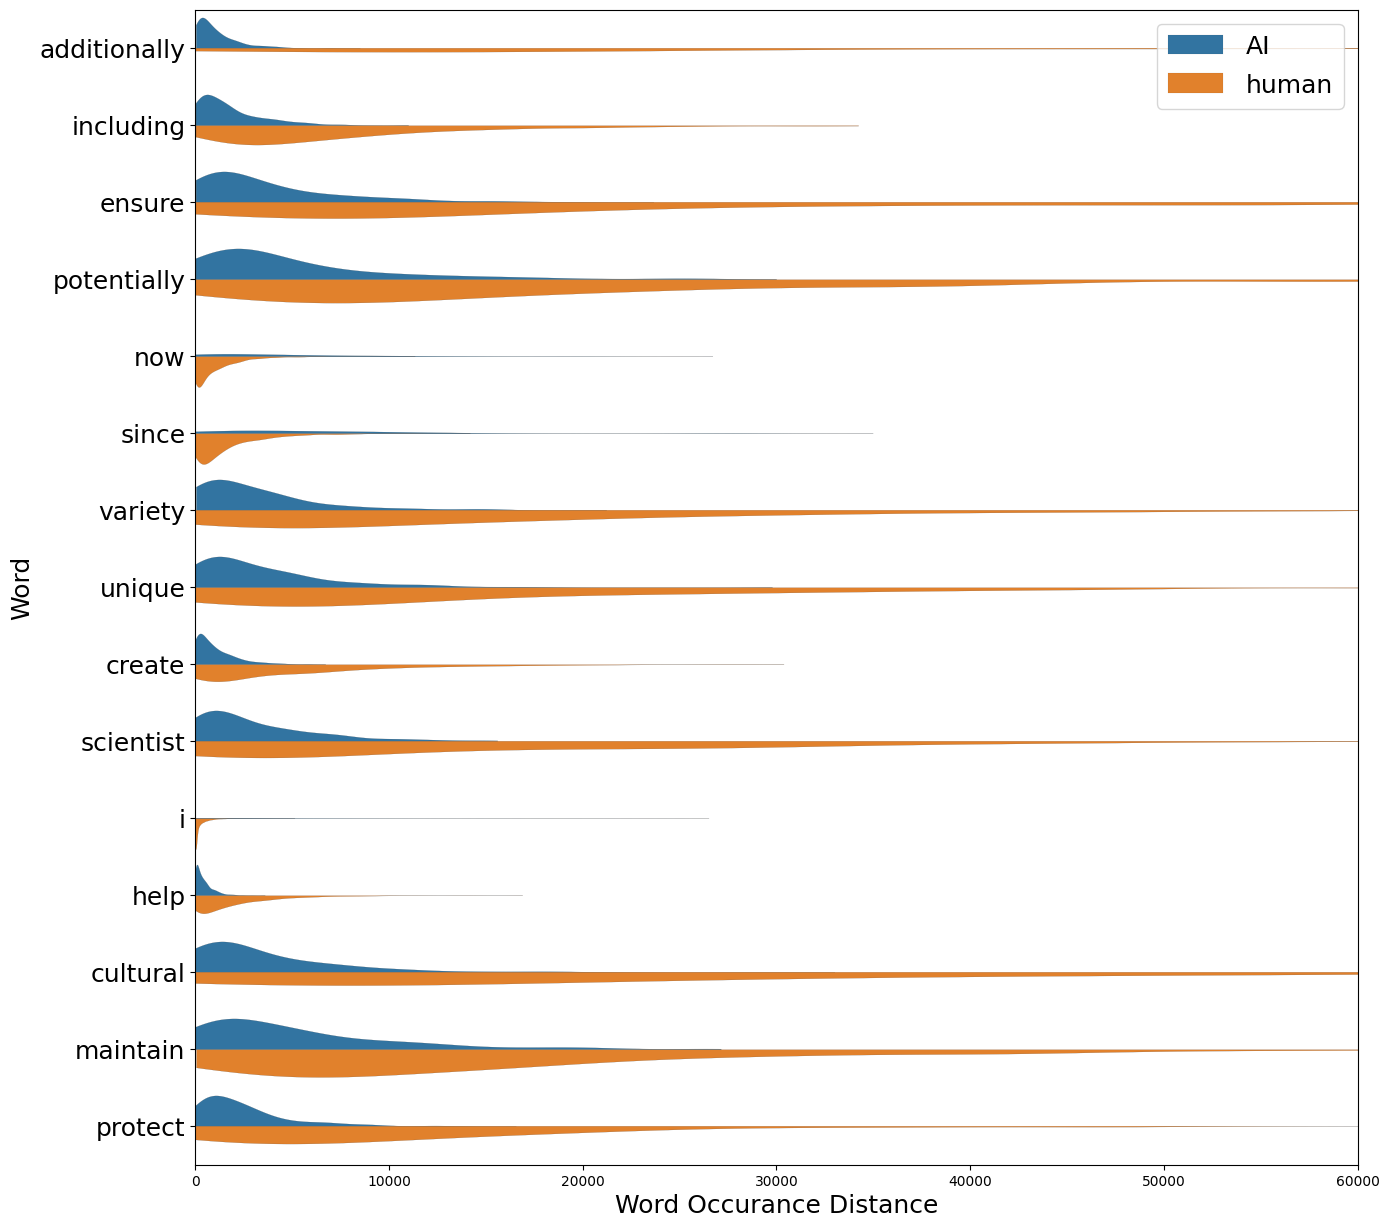

In [ ]:
#Seaborn work to make side-by-side violin plots

fig, ax = plt.subplots(1,1,figsize=(15,15))
splot = sns.violinplot(ax=ax, data=df, y="word", x="count", hue='class', edgecolor=None, inner=None, linewidth=0.1, width=0.8, split=True, cut=0, gridsize=500, scale='count')
ax.set_xlim(0,60000)
# splot.set(xscale='log')
ax.set_ylabel('Word', size=18)
ax.set_xlabel('Word Occurance Distance', size=18)
ax.get_legend().set_title("")
ax.set_yticklabels(ax.get_yticklabels(), size=18)
plt.setp(splot.get_legend().get_texts(), fontsize=18)
plt.show()

For every data point, we calculate the distribution of how long between each occurances of teh word in the human and AI data sets. We then use a Z-test to see if any of these distributions are significantly different (they are not, |Z| < 1 for all of them). This means that they cannot substantially change teh use. However, looking at the plots, we still see slightly differences in frequency, thus in aggregate, it may be able to provide some predictive help, but none of them are significanlty different unfortunately. Thus while the word frequency is different, the word distribution is not.

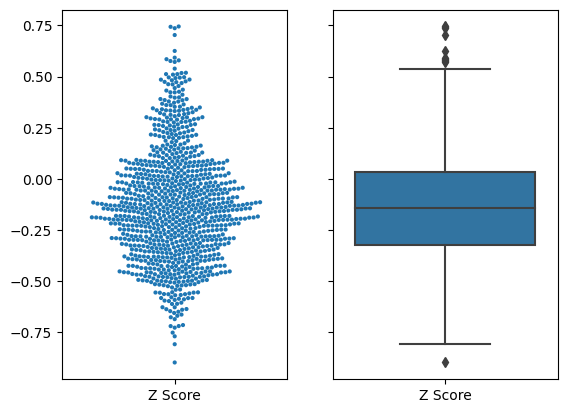

In [ ]:
#Plot scores

fig, ax = plt.subplots(1,2,sharey=True)

sm = sns.swarmplot(ax=ax[0], data=zstat.values(), size=3)
sm.set_xticks([0], ['Z Score'])
bp = sns.boxplot(ax=ax[1], data=list(zstat.values()))
bp.set_xticks([0], ['Z Score'])

In [ ]:
ai_most_short = {a:ai_word_dist[a] for (a,b) in ai_most[:30]}
human_most_short = {a:human_word_dist[a] for (a,b) in human_most[:30]}

df_ai = pd.DataFrame.from_dict(ai_most_short, orient='index').transpose()
df_ai_melted = df_ai.melt(var_name='word', value_name='count')
df_ai_melted['class'] = 'AI'

df_human = pd.DataFrame.from_dict(human_most_short, orient='index').transpose()
df_human_melted = df_human.melt(var_name='word', value_name='count')
df_human_melted['class'] = 'human'

df = pd.concat([df_ai_melted, df_human_melted])






In [ ]:
tips = sns.load_dataset("tips")
print(tips.head())

   total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4
